# Inputting Out of Distribution Data

In [1]:
from emb_net import TaskEmbeddingNet as PENUTS
import torch

model_path = "./models_penuts/emb_epoch7200_0.0010.pt"
# model_path = "./models_penuts/emb_epoch24500_0.0010_np_45.pt"
z_dim = 20
disable_pz = True
clip_siigma = False

emb_net = PENUTS(z_dim=z_dim, disable_layernorm_fc=True).to("cuda")
emb_net.load_state_dict(torch.load(model_path, map_location="cuda"))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

## Normal, Freeze, Random, No-Obj, Hidden

In [2]:
ls demos/

Freeze/  Hidden50/  Hidden64/  No_Obj/  Normal/  Random/


In [3]:
test_dir = "../data/mil_data/data_mini/sim_push_test/"

In [4]:
import os
from glob import glob
from natsort import natsorted
demo_paths_normal = natsorted(glob(os.path.join("./demos_mini/Normal", "*.gif")))
demo_paths_freeze = natsorted(glob(os.path.join("./demos_mini/Freeze", "*.gif")))
demo_paths_random = natsorted(glob(os.path.join("./demos_mini/Random", "*.gif")))
demo_paths_no_obj = natsorted(glob(os.path.join("./demos_mini/No_Obj/", "*.gif")))
demo_paths_hidden64 = natsorted(glob(os.path.join("./demos_mini/Hidden64", "*.gif")))

print(len(demo_paths_normal), len(demo_paths_freeze), len(demo_paths_random), len(demo_paths_no_obj), len(demo_paths_hidden64))

90 90 90 90 90


In [5]:
demo_paths_all = {"Normal":demo_paths_normal, "Freeze":demo_paths_freeze, \
                  "Random":demo_paths_random, "No_Obj":demo_paths_no_obj, \
                  "Hidden":demo_paths_hidden64}

In [6]:
import numpy as np
from utils import vread, poe, make_emb_input
from torch.distributions import Normal

def embedding_np(demo_path, disable_pz, clip_sigma):
    inp = make_emb_input(demo_path).to("cuda")
    
    with torch.no_grad():
        train_mu, train_logvar = torch.split(emb_net(inp), z_dim, dim=1)
    if not clip_sigma:
        train_scale = torch.exp(0.5 * train_logvar)
    else:
        train_scale = 0.1 + 0.9 * torch.sigmoid(train_logvar)
    if disable_pz:
        prior = Normal(train_mu, train_scale)
    else:
        standard_normal = Normal(torch.zeros(1, z_dim).to("cuda"), torch.ones(1, z_dim).to("cuda"))
        prior = poe(standard_normal, Normal(train_mu, train_scale), z_dim)
    # z = prior.mean
    return {"mean": prior.mean.cpu().numpy()[0], "stddev":prior.stddev.cpu().numpy()[0]}

In [7]:
embs = {}
for k,demo_paths in demo_paths_all.items():
    embs[k] = [embedding_np(path, disable_pz, clip_siigma) for path in demo_paths]

In [8]:
means_normal = np.array([emb["mean"] for emb in embs["Normal"]])
stds_normal = np.array([emb["stddev"] for emb in embs["Normal"]])

means_freeze = np.array([emb["mean"] for emb in embs["Freeze"]])
stds_freeze = np.array([emb["stddev"] for emb in embs["Freeze"]])

means_random = np.array([emb["mean"] for emb in embs["Random"]])
stds_random = np.array([emb["stddev"] for emb in embs["Random"]])

means_no_obj = np.array([emb["mean"] for emb in embs["No_Obj"]])
stds_no_obj = np.array([emb["stddev"] for emb in embs["No_Obj"]])

means_hidden = np.array([emb["mean"] for emb in embs["Hidden"]])
stds_hidden = np.array([emb["stddev"] for emb in embs["Hidden"]])

In [9]:
s_normal = stds_normal.mean()
s_freeze = stds_freeze.mean()
s_random = stds_random.mean()
s_no_obj = stds_no_obj.mean()
s_hidden = stds_hidden.mean()

In [10]:
s_normal, s_freeze, s_random, s_no_obj, s_hidden

(0.0014133806, 0.10130883, 0.020347308, 0.027308175, 0.9267801)

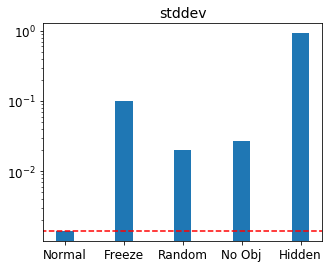

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4)); plt.title("stddev", fontsize=14)
plt.hlines([s_normal], -0.8, 5, "red", linestyles='dashed')
plt.tick_params(labelsize=12)
plt.bar(["Normal", "Freeze", "Random", "No Obj", "Hidden"], \
        [s_normal, s_freeze, s_random, s_no_obj, s_hidden], \
        width=0.3, align="center"); plt.yscale('log'); plt.show()

## 箱ひげ図にするべきかも…